
# TP CNN : License plate detection & recognition 
Binome :
- Hafdi Ramy
- Chaalal Med. Elmondhir

**Note:** The Datasets used for this project are all availible on Kaggle, therefore we can download them directly into Google Colab, using the Kaggle API as demonstrated below

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use('default')  #using black for backgrounf

## Setting up the Kaggle API

Upload the `Kaggle.json` file

In [2]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mondhirch","key":"fedebc46601d6c3faaf0aac7d923b8f7"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

### Downloading the dataset

In [4]:
#dataset 1 
!kaggle datasets download -d andrewmvd/car-plate-detection

100% 203M/203M [00:14<00:00, 15.6MB/s]
100% 203M/203M [00:14<00:00, 14.4MB/s]


In [5]:
#dataset 2
!kaggle datasets download -d achrafkhazri/labeled-licence-plates-dataset

100% 142M/142M [00:11<00:00, 17.3MB/s]
100% 142M/142M [00:11<00:00, 13.5MB/s]


Now to Unzipping

In [6]:
from zipfile import ZipFile
file_name="car-plate-detection.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")

Done


In [7]:
from zipfile import ZipFile
file_name="labeled-licence-plates-dataset.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")

Done


In [8]:
# Moving all images to the same folder

!mv "/content/dataset/train/"*.jpg "/content/images"
!mv "/content/dataset/train/"*.xml "/content/annotations"

!mv "/content/dataset/test/"*.jpg "/content/images"
!mv "/content/dataset/test/"*.xml "/content/annotations"

In [9]:
# removing unneeded files/folders

!rm -rf "dataset"
!rm "car-plate-detection.zip"
!rm "labeled-licence-plates-dataset.zip"

## Append images

We'll go through the images folder and append all images, while also resizing them to 228*228

In [10]:
IMAGE_SIZE = 228

img_dir = "images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(img)

## Getting Annotation

We'll also define the function to extract the bounding box annotations, and resize them according to the new images dimensions.

In [11]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [12]:
#Run when Resize ON
path = 'annotations/'
text_files = [path+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

### Plotting some examples

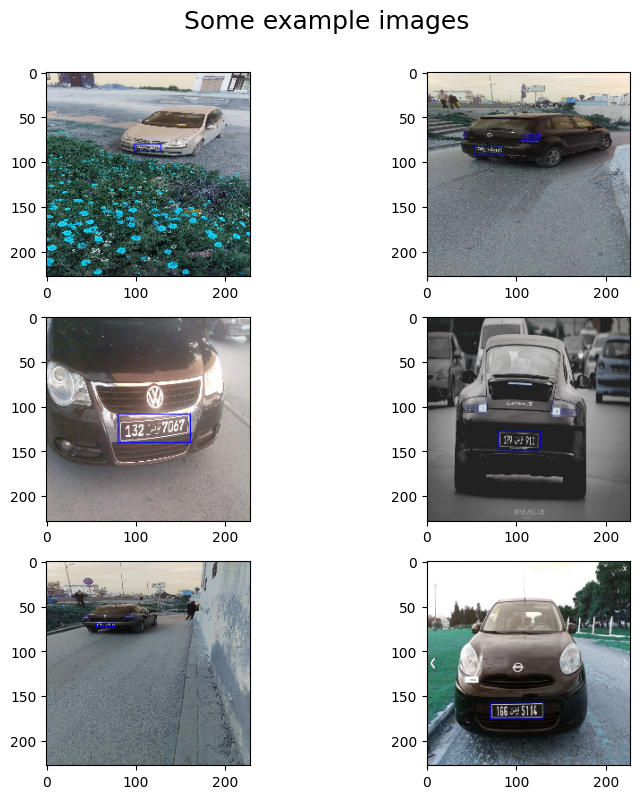

In [13]:
plt.figure(figsize=(9, 9))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Some example images", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n in range(6):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    image=X[n].copy()
    cv2.rectangle(image,(y[n][0],y[n][1]),(y[n][2],y[n][3]),(0, 0, 255))
    plt.imshow(image)

## Transform to numpy array

Next we will transform the X and Y into numpy array to use for the model

In [14]:
X=np.array(X)
y=np.array(y)

### Nnormalisation


Neural networks require normalized input

In [15]:
X = X / 255
y = y / 255

## Train/test/val  split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=14)

# Model Definition

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

In [18]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58889256/58889256 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

Now to compiling the model

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

and finally to training

In [20]:
#training the model
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, verbose=1)

Epoch 1/20
52/52 [==============================] - 16s 148ms/step - loss: 0.6696 - accuracy: 0.6492 - val_loss: 0.6530 - val_accuracy: 0.8152
Epoch 2/20
52/52 [==============================] - 5s 98ms/step - loss: 0.6354 - accuracy: 0.8429 - val_loss: 0.6485 - val_accuracy: 0.8370
Epoch 3/20
52/52 [==============================] - 5s 98ms/step - loss: 0.6290 - accuracy: 0.9050 - val_loss: 0.6501 - val_accuracy: 0.8696
Epoch 4/20
52/52 [==============================] - 5s 99ms/step - loss: 0.6265 - accuracy: 0.9233 - val_loss: 0.6469 - val_accuracy: 0.8696
Epoch 5/20
52/52 [==============================] - 5s 99ms/step - loss: 0.6246 - accuracy: 0.9367 - val_loss: 0.6473 - val_accuracy: 0.8478
Epoch 6/20
52/52 [==============================] - 5s 100ms/step - loss: 0.6241 - accuracy: 0.9403 - val_loss: 0.6474 - val_accuracy: 0.8478
Epoch 7/20
52/52 [==============================] - 5s 101ms/step - loss: 0.6236 - accuracy: 0.9598 - val_loss: 0.6472 - val_accuracy: 0.8478
Epoch 8/2

## Saving the model

In [21]:
model.save('my_model.h5', overwrite=True) 

## Evaluating

In [22]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 4s 150ms/step - loss: 0.6383 - accuracy: 0.9039


[0.638321578502655, 0.903930127620697]

## making predictions

In [23]:
y_pred = model.predict(X_test)

8/8 [==============================] - 1s 143ms/step


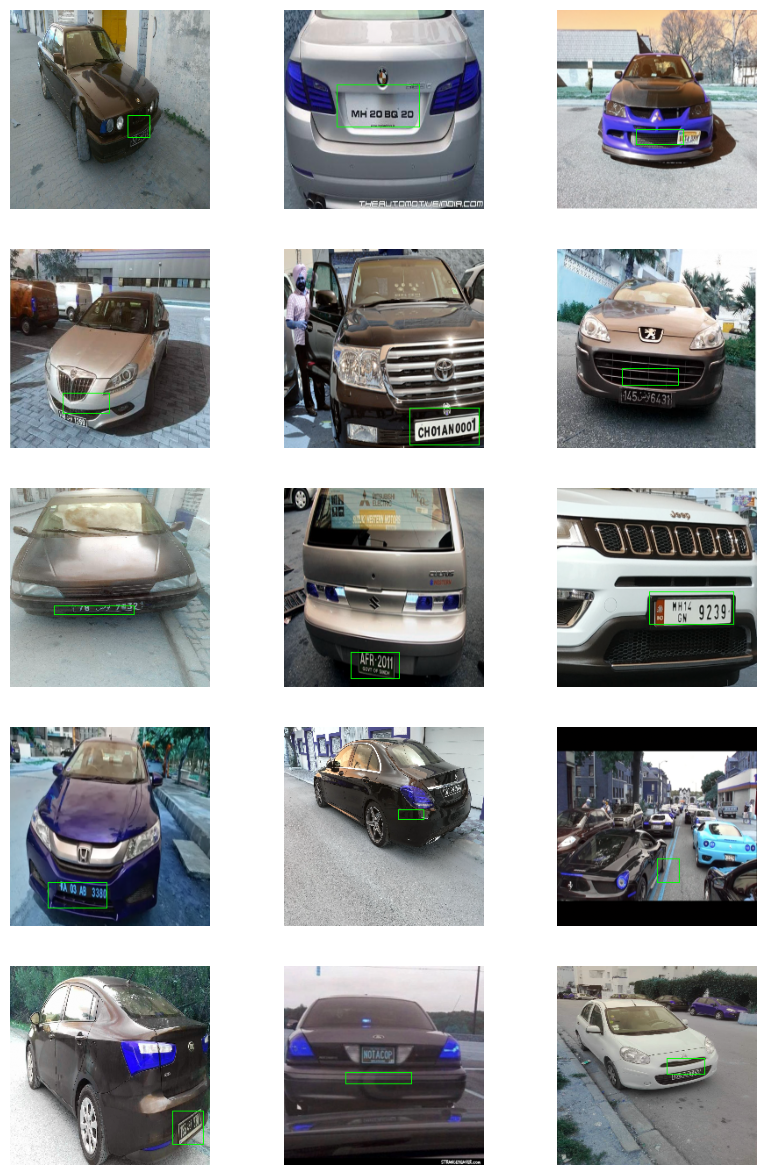

In [27]:
plt.figure(figsize=(10,15))
for i in range(0,15) :
    plt.subplot(5,3,i+1)
    plt.axis('off')
    ny = y_pred[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)